In [11]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode

In [12]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [13]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [15]:
# Define file paths
model_path = r'C:\Users\k54739\Bibi_new_thesis\saved_model\sweetcrop_simclr_model_epoch_245.pth'
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()

C:\Users\k54739\AppData\Local\Temp\ipykernel_53844\1068533374.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

# Clustering

In [16]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        #self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        #return image, label
        return image, label, img_path

def load_data(root_dir):

    #classes = ['cond7_all', 'sd_only','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_only','ex'] # curated full dataset


    #classes = ['uncure_cond7_40', 'sdonly_40','ex'] # 40 subset # 97.5
    #classes = ['cure_cond7_40', 'sdonly_40','ex'] # curated 40 subset

    #inference
    classes = ['cond7_all', 'sd_plus_dsclose','ex'] #full dataset
    #classes = ['cond7_curated', 'sd_plus_dsclose','ex'] # curated full dataset



    #classes = ['uncure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference
    #classes = ['cure_cond7_40', 'sd_plus_dsclose_40','ex'] # curated 40 subset inference

    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})

    return image_files, labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load data
image_files, labels = load_data(image_dir)

# Create the labeled datasets
labeled_dataset = LabeledImageDataset(image_files, labels)

# Define DataLoaders
batch_size = 16
loader_labeled = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)

Label distribution: {'cond7_all': 472, 'sd_plus_dsclose': 125, 'ex': 40}


for anchor,label in loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

In [17]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels, paths = [], [], []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        print(f"Batch labels shape: {batch_paths}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)
        paths.extend(batch_paths) 

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")
    print(f"Number of paths after concatenation: {len(paths)}")

    return feats, labels, paths

In [18]:
# Extract features for train and test datasets
feats, labels, paths = prepare_data_features(simclr_model, loader_labeled)

  2%|▎         | 1/40 [00:00<00:31,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7

  5%|▌         | 2/40 [00:01<00:27,  1.41it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

  8%|▊         | 3/40 [00:02<00:24,  1.48it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 10%|█         | 4/40 [00:02<00:24,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G09-T01.tiff', 'C:\\Users\\k54739\\Bib

 12%|█▎        | 5/40 [00:03<00:23,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 15%|█▌        | 6/40 [00:04<00:22,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G06-T01.tiff', 'C:\\Users\\k54739\\Bib

 18%|█▊        | 7/40 [00:04<00:22,  1.46it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B08-T

 20%|██        | 8/40 [00:05<00:22,  1.44it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C11-T01.tiff', 'C:\\Users\\k54739\\Bib

 22%|██▎       | 9/40 [00:06<00:21,  1.47it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bib

 25%|██▌       | 10/40 [00:06<00:20,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C08-T01.tiff', 

 28%|██▊       | 11/40 [00:07<00:19,  1.49it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 30%|███       | 12/40 [00:08<00:18,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B08-T01.tiff', 'C:\\User

 32%|███▎      | 13/40 [00:08<00:17,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g9_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thes

 35%|███▌      | 14/40 [00:09<00:17,  1.52it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 38%|███▊      | 15/40 [00:10<00:16,  1.54it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 40%|████      | 16/40 [00:10<00:15,  1.53it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g3_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\th

 42%|████▎     | 17/40 [00:11<00:15,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B11-T01.tiff', 'C:\\User

 45%|████▌     | 18/40 [00:12<00:14,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 48%|████▊     | 19/40 [00:12<00:13,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g5_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesi

 50%|█████     | 20/40 [00:13<00:13,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesi

 52%|█████▎    | 21/40 [00:14<00:12,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_C11-T01.tiff', 'C:\\Users\\k54739\\Bib

 55%|█████▌    | 22/40 [00:14<00:12,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g2_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds62_g2_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\

 57%|█████▊    | 23/40 [00:15<00:11,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds41_g3_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g5_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\th

 60%|██████    | 24/40 [00:16<00:10,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D04-T01.tiff', 'C:\\Users\\k54739\\Bib

 62%|██████▎   | 25/40 [00:16<00:09,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g5_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_B07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classifi

 65%|██████▌   | 26/40 [00:17<00:09,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds1B_g9_c10.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classif

 68%|██████▊   | 27/40 [00:18<00:08,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds62_g2_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\th

 70%|███████   | 28/40 [00:18<00:08,  1.49it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g5_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E4.tif', 'C:\\Users\\k54739\\Bibi_new_the

 72%|███████▎  | 29/40 [00:19<00:07,  1.49it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\

 75%|███████▌  | 30/40 [00:20<00:06,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds42_g2_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E2.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C11-T01.tiff', 'C:\\Users\\k

 78%|███████▊  | 31/40 [00:20<00:05,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds62_g2_B03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g9_C11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_B06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_D08-T01.tiff', 'C:\\Users\\k54739\\

 80%|████████  | 32/40 [00:21<00:05,  1.50it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_G09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_G02-T01.tiff', 'C:\\Users\\k54739\\Bib

 82%|████████▎ | 33/40 [00:22<00:04,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_C06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 85%|████████▌ | 34/40 [00:22<00:03,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_B04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g8_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_G05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new

 88%|████████▊ | 35/40 [00:23<00:03,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_G11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_D11-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds61_g6_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g2_B03-T01.tiff', 'C:\\Users\\k54739\\

 90%|█████████ | 36/40 [00:24<00:02,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_E09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_1B_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 92%|█████████▎| 37/40 [00:24<00:01,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\ex\\ds62_g8_B10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_F03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds1b_g5_E5.tif', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_G07-T01.tiff', 'C:\\Us

 95%|█████████▌| 38/40 [00:25<00:01,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_C03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_F04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E03-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_B08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_61_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_E08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesi

 98%|█████████▊| 39/40 [00:26<00:00,  1.51it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_C10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_C08-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.14_Day10_B09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.09_Day10_D07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_51_E02-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_G04-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F11-T01.tiff', 'C:\

100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

Batch features shape: torch.Size([13, 512])
Batch labels shape: torch.Size([13])
Batch labels shape: ['C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_42_C05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_D09-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_41_F06-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.04_Day10_C07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_62_F07-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\sd_04_F10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\sd_RBT_01.10_Day10_D10-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\sd_plus_dsclose\\ds41_g5_E05-T01.tiff', 'C:\\Users\\k54739\\Bibi_new_thesis\\thesis\\classification\\cond7_all\\ds_52_E04-T01.tiff', 'C:\\Users\\k54

In [19]:
# Convert features and labels to NumPy arrays
feats_np = feats.numpy()  # Features in shape (60, 512)
feats_np_norm = normalize(feats_np, axis=1)
labels_np = labels.numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (637, 512)
Shape of labels: (637,)


In [20]:
from collections import Counter
import numpy as np
from sklearn.preprocessing import normalize

# Functions: K-Means initialization, assignment, and computation
def kMeans_init_centroids(X, K):
    """Initialize centroids randomly from the dataset."""
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

def find_closest_centroids(X, centroids):
    """Assign data points to closest centroids using cosine similarity."""
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Cosine similarity
        idx[i] = np.argmax(similarities)  # Assign to the most similar centroid
    return idx

def compute_centroids(X, idx, K):
    """Compute new centroids based on assigned clusters."""
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids = normalize(centroids, axis=1)  # Normalize centroids
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    """Run the K-Means algorithm."""
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0], dtype=int)
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

'''# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Assign each label to the cluster where it is most common
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts '''

# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Track clusters already assigned to labels
    assigned_clusters = set()

    # Assign each label to the cluster where it is most common, respecting the rule
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            # Skip clusters already assigned to another label
            if cluster in assigned_clusters:
                continue
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        # Assign this label to the cluster and mark the cluster as used
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            assigned_clusters.add(assigned_cluster)
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts

def main_kMeans_experiment_with_paths(X, labels_np, paths, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None
    best_cluster_paths = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
            
            # Group paths by cluster
            cluster_paths = {cluster: [] for cluster in range(K)}
            for i, cluster in enumerate(idx):
                cluster_paths[cluster].append(paths[i])
            best_cluster_paths = cluster_paths
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
        print(f"Paths in Cluster {cluster}:")
        for path in best_cluster_paths[cluster]:
            print(f"  {path}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts, best_cluster_paths


# Run the updated K-Means experiment
K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts, best_cluster_paths = main_kMeans_experiment_with_paths(
    feats_np, labels_np, paths, K, num_runs, max_iters
)

Run 1/400, Accuracy: 0.5557
Run 2/400, Accuracy: 0.5416
Run 3/400, Accuracy: 0.5542
Run 4/400, Accuracy: 0.6279
Run 5/400, Accuracy: 0.5589
Run 6/400, Accuracy: 0.5542
Run 7/400, Accuracy: 0.5416
Run 8/400, Accuracy: 0.5495
Run 9/400, Accuracy: 0.5322
Run 10/400, Accuracy: 0.5730
Run 11/400, Accuracy: 0.6342
Run 12/400, Accuracy: 0.5573
Run 13/400, Accuracy: 0.5275
Run 14/400, Accuracy: 0.5416
Run 15/400, Accuracy: 0.8713
Run 16/400, Accuracy: 0.5353
Run 17/400, Accuracy: 0.8776
Run 18/400, Accuracy: 0.5651
Run 19/400, Accuracy: 0.5557
Run 20/400, Accuracy: 0.6342
Run 21/400, Accuracy: 0.6342
Run 22/400, Accuracy: 0.5573
Run 23/400, Accuracy: 0.5636
Run 24/400, Accuracy: 0.5667
Run 25/400, Accuracy: 0.8571
Run 26/400, Accuracy: 0.5416
Run 27/400, Accuracy: 0.5369
Run 28/400, Accuracy: 0.5385
Run 29/400, Accuracy: 0.5604
Run 30/400, Accuracy: 0.6342
Run 31/400, Accuracy: 0.5416
Run 32/400, Accuracy: 0.5479
Run 33/400, Accuracy: 0.5416
Run 34/400, Accuracy: 0.8917
Run 35/400, Accuracy: 0

In [ ]:
s

In [21]:
from collections import Counter
import numpy as np
from sklearn.preprocessing import normalize

# Functions: K-Means initialization, assignment, and computation
def kMeans_init_centroids(X, K):
    """Initialize centroids randomly from the dataset."""
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

def find_closest_centroids(X, centroids):
    """Assign data points to closest centroids using cosine similarity."""
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Cosine similarity
        idx[i] = np.argmax(similarities)  # Assign to the most similar centroid
    return idx

def compute_centroids(X, idx, K):
    """Compute new centroids based on assigned clusters."""
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids = normalize(centroids, axis=1)  # Normalize centroids
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    """Run the K-Means algorithm."""
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0], dtype=int)
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

'''# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Assign each label to the cluster where it is most common
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts '''

# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Track clusters already assigned to labels
    assigned_clusters = set()

    # Assign each label to the cluster where it is most common, respecting the rule
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            # Skip clusters already assigned to another label
            if cluster in assigned_clusters:
                continue
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        # Assign this label to the cluster and mark the cluster as used
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            assigned_clusters.add(assigned_cluster)
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts

def main_kMeans_experiment_with_paths(X, labels_np, paths, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None
    best_cluster_paths = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
            
            # Group paths by cluster
            cluster_paths = {cluster: [] for cluster in range(K)}
            for i, cluster in enumerate(idx):
                cluster_paths[cluster].append(paths[i])
            best_cluster_paths = cluster_paths
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
        print(f"Paths in Cluster {cluster}:")
        for path in best_cluster_paths[cluster]:
            print(f"  {path}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts, best_cluster_paths


# Run the updated K-Means experiment
K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts, best_cluster_paths = main_kMeans_experiment_with_paths(
    feats_np, labels_np, paths, K, num_runs, max_iters
)

Run 1/400, Accuracy: 0.6279
Run 2/400, Accuracy: 0.5416
Run 3/400, Accuracy: 0.5400
Run 4/400, Accuracy: 0.5495
Run 5/400, Accuracy: 0.8791
Run 6/400, Accuracy: 0.5353
Run 7/400, Accuracy: 0.5636
Run 8/400, Accuracy: 0.5510
Run 9/400, Accuracy: 0.6279
Run 10/400, Accuracy: 0.6279
Run 11/400, Accuracy: 0.5730
Run 12/400, Accuracy: 0.6342
Run 13/400, Accuracy: 0.8948
Run 14/400, Accuracy: 0.5683
Run 15/400, Accuracy: 0.5306
Run 16/400, Accuracy: 0.5322
Run 17/400, Accuracy: 0.5322
Run 18/400, Accuracy: 0.5730
Run 19/400, Accuracy: 0.5385
Run 20/400, Accuracy: 0.5573
Run 21/400, Accuracy: 0.6358
Run 22/400, Accuracy: 0.5730
Run 23/400, Accuracy: 0.8352
Run 24/400, Accuracy: 0.5683
Run 25/400, Accuracy: 0.6279
Run 26/400, Accuracy: 0.6279
Run 27/400, Accuracy: 0.6499
Run 28/400, Accuracy: 0.5385
Run 29/400, Accuracy: 0.5636
Run 30/400, Accuracy: 0.5306
Run 31/400, Accuracy: 0.9576
Run 32/400, Accuracy: 0.5699
Run 33/400, Accuracy: 0.5463
Run 34/400, Accuracy: 0.6342
Run 35/400, Accuracy: 0

In [22]:
s

NameError: name 's' is not defined

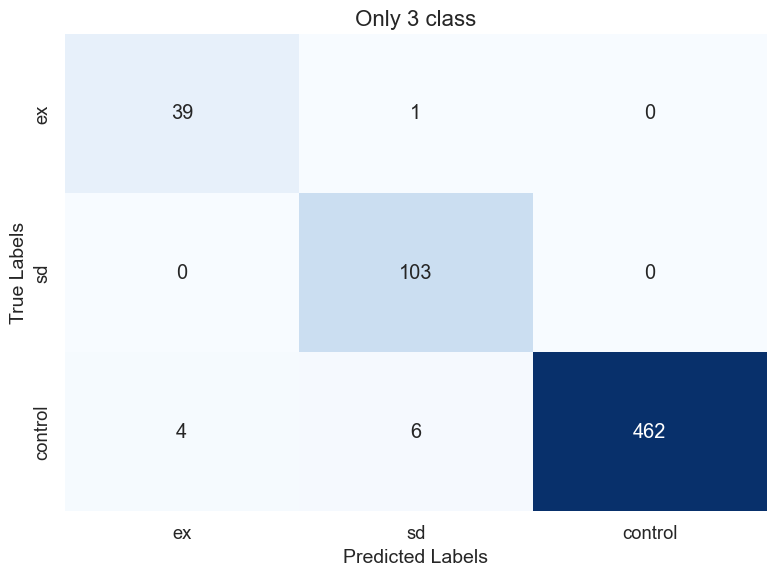

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Define confusion matrix values
labels = ['ex', 'sd', 'control']  # Class labels
conf_matrix = np.array([
    [39, 1, 0],     # Row for 'ex'
    [0, 103, 0],    # Row for 'sd'
    [4, 6, 462]     # Row for 'control'
])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Add labels, title, and other details
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title("Only 3 class", fontsize=16)
plt.tight_layout()

# Display the plot
plt.show()


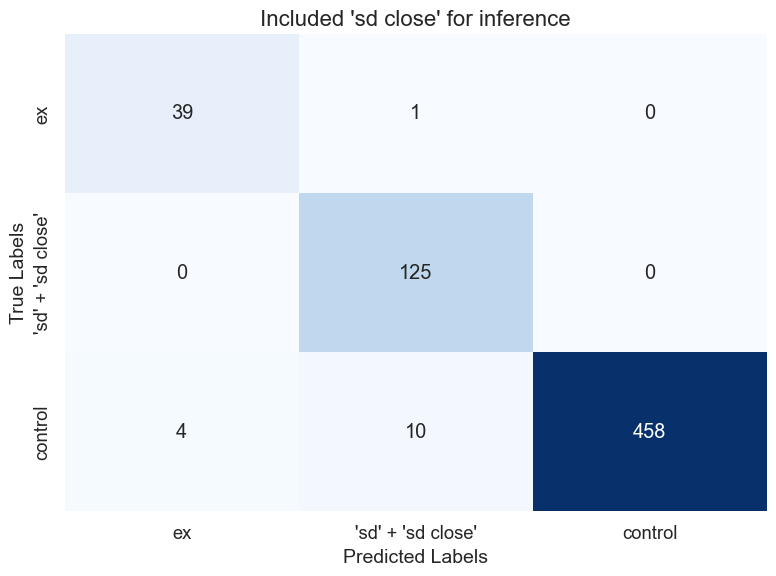

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Define confusion matrix values
labels = ['ex', "'sd' + 'sd close'", 'control']  # Class labels
conf_matrix = np.array([
    [39, 1, 0],     # Row for 'ex'
    [0, 125, 0],    # Row for 'sd'
    [4, 10, 458]     # Row for 'control'
])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Add labels, title, and other details
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title("Included 'sd close' for inference", fontsize=16)
plt.tight_layout()

# Display the plot
plt.show()


In [8]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [63]:
# Extract features for train and test datasets
feats_simclr = prepare_data_features(simclr_model, loader_labeled)

 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:04,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:02<00:03,  1.29it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:03<00:03,  1.28it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:03<00:02,  1.26it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:04<00:01,  1.31it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:05<00:00,  1.34it/s]

Batch features shape: torch.Size([16, 20])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

Batch features shape: torch.Size([8, 20])
Batch labels shape: torch.Size([8])
Features shape after concatenation: torch.Size([120, 20])
Labels shape after concatenation: torch.Size([120])


In [64]:
# Convert features and labels to NumPy arrays
feats_np = feats_simclr.tensors[0].numpy()  # Features in shape (60, 512)
feats_np_norm = normalize(feats_np, axis=1)
labels_np = feats_simclr.tensors[1].numpy()  # Corresponding labels

# Check the shapes
print("Shape of features (for K-Means):", feats_np.shape)
print("Shape of labels:", labels_np.shape)

Shape of features (for K-Means): (120, 20)
Shape of labels: (120,)


In [65]:
from collections import Counter
import numpy as np
from sklearn.preprocessing import normalize

# Functions: K-Means initialization, assignment, and computation
def kMeans_init_centroids(X, K):
    """Initialize centroids randomly from the dataset."""
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

def find_closest_centroids(X, centroids):
    """Assign data points to closest centroids using cosine similarity."""
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Cosine similarity
        idx[i] = np.argmax(similarities)  # Assign to the most similar centroid
    return idx

def compute_centroids(X, idx, K):
    """Compute new centroids based on assigned clusters."""
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids = normalize(centroids, axis=1)  # Normalize centroids
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    """Run the K-Means algorithm."""
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0], dtype=int)
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Assign each label to the cluster where it is most common
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts 

'''# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Track clusters already assigned to labels
    assigned_clusters = set()

    # Assign each label to the cluster where it is most common, respecting the rule
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            # Skip clusters already assigned to another label
            if cluster in assigned_clusters:
                #continue
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        # Assign this label to the cluster and mark the cluster as used
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            assigned_clusters.add(assigned_cluster)
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts'''

def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts


'''
# Main loop for running K-Means multiple times
def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")'''

    

# Example usage
# Assuming `feats_np_norm` is your normalized feature matrix and `labels_np` contains true labels
K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts = main_kMeans_experiment(feats_np_norm, labels_np, K, num_runs, max_iters)


Run 1/400, Accuracy: 0.7000
Run 2/400, Accuracy: 0.7083
Run 3/400, Accuracy: 0.6583
Run 4/400, Accuracy: 0.8083
Run 5/400, Accuracy: 0.6417
Run 6/400, Accuracy: 0.7083
Run 7/400, Accuracy: 0.5583
Run 8/400, Accuracy: 0.7250
Run 9/400, Accuracy: 0.5917
Run 10/400, Accuracy: 0.7417
Run 11/400, Accuracy: 0.5667
Run 12/400, Accuracy: 0.7333
Run 13/400, Accuracy: 0.8583
Run 14/400, Accuracy: 0.7083
Run 15/400, Accuracy: 0.8667
Run 16/400, Accuracy: 0.5500
Run 17/400, Accuracy: 0.7083
Run 18/400, Accuracy: 0.5667
Run 19/400, Accuracy: 0.6333
Run 20/400, Accuracy: 0.7417
Run 21/400, Accuracy: 0.7417
Run 22/400, Accuracy: 0.6250
Run 23/400, Accuracy: 0.6917
Run 24/400, Accuracy: 0.7167
Run 25/400, Accuracy: 0.7083
Run 26/400, Accuracy: 0.6833
Run 27/400, Accuracy: 0.6333
Run 28/400, Accuracy: 0.6917
Run 29/400, Accuracy: 0.7500
Run 30/400, Accuracy: 0.6833
Run 31/400, Accuracy: 0.7083
Run 32/400, Accuracy: 0.7667
Run 33/400, Accuracy: 0.7333
Run 34/400, Accuracy: 0.7833
Run 35/400, Accuracy: 0

In [66]:
431+125+39

595

In [67]:
279+39+125

443

In [68]:
443/445

0.9955056179775281

In [69]:
595/637

0.9340659340659341

In [70]:
404/637

0.6342229199372057

CORRECTED ACCURACY

In [71]:
from collections import Counter
import numpy as np
from sklearn.preprocessing import normalize

# Functions: K-Means initialization, assignment, and computation
def kMeans_init_centroids(X, K):
    """Initialize centroids randomly from the dataset."""
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

def find_closest_centroids(X, centroids):
    """Assign data points to closest centroids using cosine similarity."""
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        similarities = np.dot(centroids, X[i])  # Cosine similarity
        idx[i] = np.argmax(similarities)  # Assign to the most similar centroid
    return idx

def compute_centroids(X, idx, K):
    """Compute new centroids based on assigned clusters."""
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)
    centroids = normalize(centroids, axis=1)  # Normalize centroids
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10):
    """Run the K-Means algorithm."""
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0], dtype=int)
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, K)
    return centroids, idx

'''# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Assign each label to the cluster where it is most common
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts '''

# Accuracy calculation and main experiment loop
def calculate_accuracy(idx, labels_np, K=3):
    """Calculate accuracy for a given set of cluster assignments."""
    total_samples = len(labels_np)
    cluster_label_counts = {}
    label_to_cluster = {}
    correctly_classified = 0

    # Count true labels in each cluster
    for cluster in range(K):
        cluster_indices = np.where(idx == cluster)[0]
        cluster_labels = labels_np[cluster_indices]
        label_counts = Counter(cluster_labels)
        cluster_label_counts[cluster] = label_counts
    
    # Track clusters already assigned to labels
    assigned_clusters = set()

    # Assign each label to the cluster where it is most common, respecting the rule
    for label in range(3):  # Assuming 3 classes: 0, 1, 2
        max_count = 0
        assigned_cluster = None
        for cluster, label_counts in cluster_label_counts.items():
            # Skip clusters already assigned to another label
            if cluster in assigned_clusters:
                continue
            if label_counts[label] > max_count:
                max_count = label_counts[label]
                assigned_cluster = cluster
        # Assign this label to the cluster and mark the cluster as used
        if assigned_cluster is not None:
            label_to_cluster[label] = assigned_cluster
            assigned_clusters.add(assigned_cluster)
            correctly_classified += max_count

    accuracy = correctly_classified / total_samples
    return accuracy, cluster_label_counts

def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None
    best_centroids = None
    best_idx = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
            best_centroids = centroids
            best_idx = idx
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")
    
    # Return the best centroids and idx along with accuracy
    return best_accuracy, best_centroids, best_idx, best_cluster_counts


'''
# Main loop for running K-Means multiple times
def main_kMeans_experiment(X, labels_np, K=3, num_runs=100, max_iters=50):
    accuracies = []
    best_accuracy = 0
    best_cluster_counts = None

    for run in range(num_runs):
        # Initialize centroids randomly
        initial_centroids = kMeans_init_centroids(X, K)
        
        # Run K-Means
        centroids, idx = run_kMeans(X, initial_centroids, max_iters)
        
        # Calculate accuracy
        accuracy, cluster_counts = calculate_accuracy(idx, labels_np, K)
        accuracies.append(accuracy)
        
        # Track the best run
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cluster_counts = cluster_counts
        
        print(f"Run {run + 1}/{num_runs}, Accuracy: {accuracy:.4f}")

    # Print final results
    print("\n=== Final Results ===")
    print(f"Max Accuracy: {best_accuracy:.4f}")
    print("Cluster Descriptions:")
    for cluster, counts in best_cluster_counts.items():
        print(f"Cluster {cluster} has true labels: {counts}")'''

    

# Example usage
# Assuming `feats_np_norm` is your normalized feature matrix and `labels_np` contains true labels
K = 3  # Number of clusters
num_runs = 400  # Number of K-Means runs
max_iters = 50  # Maximum iterations per run

best_accuracy, best_centroids, best_idx, best_cluster_counts = main_kMeans_experiment(feats_np_norm, labels_np, K, num_runs, max_iters)


Run 1/400, Accuracy: 0.6417
Run 2/400, Accuracy: 0.8000
Run 3/400, Accuracy: 0.6667
Run 4/400, Accuracy: 0.8083
Run 5/400, Accuracy: 0.4750
Run 6/400, Accuracy: 0.6917
Run 7/400, Accuracy: 0.7083
Run 8/400, Accuracy: 0.6500
Run 9/400, Accuracy: 0.7417
Run 10/400, Accuracy: 0.7667
Run 11/400, Accuracy: 0.7000
Run 12/400, Accuracy: 0.6250
Run 13/400, Accuracy: 0.6500
Run 14/400, Accuracy: 0.7167
Run 15/400, Accuracy: 0.8583
Run 16/400, Accuracy: 0.6583
Run 17/400, Accuracy: 0.6167
Run 18/400, Accuracy: 0.7083
Run 19/400, Accuracy: 0.6333
Run 20/400, Accuracy: 0.5833
Run 21/400, Accuracy: 0.5583
Run 22/400, Accuracy: 0.6250
Run 23/400, Accuracy: 0.7417
Run 24/400, Accuracy: 0.8000
Run 25/400, Accuracy: 0.7083
Run 26/400, Accuracy: 0.6250
Run 27/400, Accuracy: 0.7083
Run 28/400, Accuracy: 0.5750
Run 29/400, Accuracy: 0.6667
Run 30/400, Accuracy: 0.6417
Run 31/400, Accuracy: 0.7250
Run 32/400, Accuracy: 0.7500
Run 33/400, Accuracy: 0.7000
Run 34/400, Accuracy: 0.8000
Run 35/400, Accuracy: 0

In [72]:
ss

NameError: name 'ss' is not defined

In [87]:
456+39+125

620

In [88]:
620/637

0.9733124018838305

In [100]:
438/445

0.9842696629213483

In [191]:
425+125+40

590

In [192]:
590/637

0.9262166405023547

In [193]:
124+406+40

570

In [194]:
570/637

0.8948194662480377

In [195]:
from collections import Counter
import numpy as np

# Number of clusters
K = len(np.unique(best_idx))

# Total number of samples
total_samples = len(labels_np)

# Dictionary to track the cluster assigned to each label
label_to_cluster = {}

# Variable to count correctly classified samples
correctly_classified = 0

# Iterate over each cluster and count the true labels in that cluster
cluster_label_counts = {}  # To store the counts for each cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(best_idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Save label counts for this cluster
    cluster_label_counts[cluster] = label_counts

# Track clusters already assigned to labels
assigned_clusters = set()

# Assign each label to the cluster where it is most common, respecting the rule
for label in range(3):  # Assuming 3 classes: 0, 1, 2
    max_count = 0
    assigned_cluster = None
    for cluster, label_counts in cluster_label_counts.items():
        # Skip clusters already assigned to another label
        if cluster in assigned_clusters:
            continue
        if label_counts[label] > max_count:
            max_count = label_counts[label]
            assigned_cluster = cluster
    # Assign this label to the cluster and mark the cluster as used
    if assigned_cluster is not None:
        label_to_cluster[label] = assigned_cluster
        assigned_clusters.add(assigned_cluster)
        correctly_classified += max_count

# Calculate accuracy
accuracy = correctly_classified / total_samples

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9138


In [196]:
# Track clusters already assigned to labels
assigned_clusters = set()

if cluster in assigned_clusters:
            continue

assigned_clusters.add(assigned_cluster)

SyntaxError: 'continue' not properly in loop (3235297709.py, line 5)

SKLEARN

In [150]:
from sklearn.metrics.pairwise import cosine_similarity

In [151]:
# Define KMeansCosine class
class KMeansCosine:
    def __init__(self, n_clusters=2, max_iter=300, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        # Normalize the data to unit vectors
        X_normalized = X / np.linalg.norm(X, axis=1)[:, np.newaxis]

        # Initialize centroids randomly from the data points
        np.random.seed(self.random_state)
        initial_indices = np.random.choice(X_normalized.shape[0], self.n_clusters, replace=False)
        centroids = X_normalized[initial_indices]

        # Track the minimum cost and corresponding labels/centroids
        best_cost = float('inf')
        best_labels = None
        best_centroids = None


        for _ in range(self.max_iter):
            # Compute the cosine similarity and distance
            similarities = cosine_similarity(X_normalized, centroids)
            cosine_dist = 1 - similarities
            cost = np.sum(cosine_dist)
            #print(f"Iteration cost: {cost}")

            # Update best cost and corresponding labels/centroids if the current cost is lower
            if cost < best_cost:
                best_cost = cost
                best_labels = np.argmax(similarities, axis=1)
                best_centroids = centroids.copy()

            # Assign clusters based on the highest similarity (lowest distance)
            labels = np.argmax(similarities, axis=1)

            # Update centroids by taking the mean of the points in each cluster
            new_centroids = np.array([X_normalized[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            new_centroids /= np.linalg.norm(new_centroids, axis=1)[:, np.newaxis]

            # Check for convergence (if centroids do not change)
            if np.allclose(centroids, new_centroids, atol=1e-6):  # Use np.allclose for numerical stability
                break

            centroids = new_centroids

        # Store final centroids and labels
        self.labels_ = labels
        self.centroids_ = centroids
        self.best_labels_ = best_labels
        self.best_centroids_ = best_centroids
        self.best_cost_ = best_cost

In [152]:
kmeans_cosine = KMeansCosine(n_clusters=3, max_iter=100, random_state=11)
kmeans_cosine.fit(feats_np)

#print("Final Cluster Labels:", kmeans_cosine.labels_)
#print("Final Centroids:", kmeans_cosine.centroids_)
#print("Best Cluster Labels with Lowest Cost:", kmeans_cosine.best_labels_)
#print("Best Centroids with Lowest Cost:", kmeans_cosine.best_centroids_)
#print("Lowest Cost:", kmeans_cosine.best_cost_)

In [153]:
idx = kmeans_cosine.labels_
idx

array([2, 2, 0, 1, 0, 1, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0,
       1, 1, 2, 0, 2, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 2,
       0, 2, 2, 1, 0, 0, 1, 2, 1, 0, 1, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2,
       0, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 1, 0, 2, 1, 1,
       0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1,
       2, 1, 0, 0, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 2, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0,
       2, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0,
       2, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 2, 1, 2,
       1, 1, 1, 0, 2, 0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 1, 2, 2, 1, 1, 2, 2,
       1, 2, 2, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 1, 0, 2, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1,
       0, 0, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1,

In [154]:
# `idx` contains the cluster assignments from KMeans
#  `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")


Cluster 0 has true labels: Counter({1: 123, 0: 52, 2: 40})
Cluster 1 has true labels: Counter({0: 208, 1: 2})
Cluster 2 has true labels: Counter({0: 212})


In [155]:
num = 49+ 164

In [156]:
num/615

0.3463414634146341

full Dataset
1 = 58.7
2 = 55.60
3 = 

In [157]:
# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels

In [158]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 85.24%


From scratch

In [159]:
# K-Means initialization function
def kMeans_init_centroids(X, K):
    randidx = np.random.permutation(X.shape[0])
    centroids = X[randidx[:K]]
    return centroids

# Function to find the closest centroids using Cosine Similarity
def find_closest_centroids(X, centroids):
    # Normalize both the data points and centroids to ensure we compute cosine similarity
    #X_norm = normalize(X, axis=1)
    #centroids_norm = normalize(centroids, axis=1)
    
    # Assign data points to closest centroids based on cosine similarity
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        # Compute cosine similarity
        similarities = np.dot(centroids, X[i])  # Dot product gives cosine similarity
        idx[i] = np.argmax(similarities)  # We want the most similar (highest value)
    return idx

# Function to compute new centroids
def compute_centroids(X, idx, K):
    centroids = np.zeros((K, X.shape[1]))  # Use shape[1] for features
    for k in range(K):
        points = X[idx == k]
        if len(points) > 0:
            centroids[k] = np.mean(points, axis=0)   # noralised vectors mean maynot be normalised. hence we normalise before calculating mean.https://chatgpt.com/share/671b97a7-ec2c-8010-af33-af106df0a25c
            centroids_norm = normalize(centroids, axis=1)
    return centroids_norm

# Function to run K-Means algorithm with cost tracking (using Cosine Similarity)
def run_kMeans(X, initial_centroids, max_iters=10):
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    idx = np.zeros(X.shape[0])
    


    for i in range(max_iters):
        #print(f"K-Means iteration {i}/{max_iters - 1}")
        
        # Assign each data point to the closest centroid using cosine similarity
        idx = find_closest_centroids(X, centroids)
        
        # Compute new centroids
        centroids = compute_centroids(X, idx, K)

        # Calculate cost function for the current centroids using cosine distance

        # 1. Compute cosine similarity
        sim = np.dot(X, centroids.T)
        #print(sim.shape)
        #print(sim)
        # 2. Calculate cosine distance
        cosine_dist = 1 - sim
        #print(cosine_dist.shape)
        #print(cosine_dist)
        # 3. Find maximum cosine distance for each data point
        #max_cosine_dist = cosine_dist.max(axis=1)
        #print(max_cosine_dist.shape)
        #print(max_cosine_dist)
        cost = np.sum(cosine_dist)

        # 4. Sum of all maximum distances
        #cost = np.sum(max_cosine_dist)

        #cost = np.sum(1 - np.dot(X_norm, centroids_norm.T).max(axis=1))  # Cosine distance = 1 - cosine similarity  
        #print(f"Cost function value: {cost}")  # Print the cost function value

        

   # Indicate which iteration was chosen
    return centroids,idx  # Return the best centroids


In [160]:
# Main function to run the K-Means algorithm

K = 3                     # Set number of clusters
initial_centroids = kMeans_init_centroids(feats_np_norm, K)  # Step 3: Initialize centroids
max_iters = 50                # Step 4: Number of iterations
centroids, idx = run_kMeans(feats_np_norm, initial_centroids, max_iters)  # Step 5: Run K-Means
#print("Final centroids:", centroids)  # Output the final centroids

from collections import Counter
import numpy as np

# Assuming `idx` contains the cluster assignments from KMeans
# and `labels` contains the true labels

K = len(np.unique(idx))  # Number of clusters

# Iterate over each cluster and count the true labels in that cluster
for cluster in range(K):
    # Find the indices of images assigned to the current cluster
    cluster_indices = np.where(idx == cluster)[0]
    
    # Get the true labels for the images in this cluster
    cluster_labels = labels_np[cluster_indices]
    
    # Use Counter to count occurrences of each label in the cluster
    label_counts = Counter(cluster_labels)
    
    # Print the result
    print(f"Cluster {cluster} has true labels: {label_counts}")

Cluster 0 has true labels: Counter({0: 208})
Cluster 1 has true labels: Counter({1: 123, 0: 52, 2: 40})
Cluster 2 has true labels: Counter({0: 212, 1: 2})


In [161]:
num = 63+191
num/(280+40+103)

0.6004728132387707

In [162]:
after full 
56.26
60.04

SyntaxError: invalid syntax (2917547872.py, line 1)

In [ ]:
after curated full 
48.22
46.80
49.17
53.12




In [571]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 76.75%


SyntaxError: invalid syntax (199546805.py, line 1)

In [482]:
after uncure 40
75.83

SyntaxError: invalid syntax (1526063840.py, line 1)

In [425]:
num = 103 + 413 + 40
num/615

0.9040650406504065

In [342]:
full Dataset
1 = 50.57
2= 55.
3. 58
4= 51.86
5 = 54.95
6 = 53.33
7 = 90.4

SyntaxError: invalid syntax (3635306252.py, line 1)

In [343]:
strong curated full

one = 62.41,
two = 62.41,
three = 68.08,
four= 85.58,
5 = 62.17,
6 = 68.08,
7 = 62.88,
8 = 68.08
9 = 62.17
10 = 62.17
11 = 100


SyntaxError: invalid syntax (686611731.py, line 1)

In [344]:
from scipy.stats import mode
import numpy as np

# Function to reorder K-Means labels to match true labels
def reorder_labels(true_labels, predicted_labels):
    reordered_labels = np.zeros_like(predicted_labels)

    for cluster in np.unique(predicted_labels):
        mask = (predicted_labels == cluster)
        # Use mode and handle cases where mode() returns a scalar
        most_common_label = mode(true_labels[mask], axis=None).mode  # Get the mode for the current cluster
        if isinstance(most_common_label, np.ndarray):
            most_common_label = most_common_label[0]  # Safely extract the mode value if it's an array
        
        reordered_labels[mask] = most_common_label

    return reordered_labels




In [345]:
# Apply this after running K-Means
reordered_idx = reorder_labels(labels_np, idx)

# Now you can compare `reordered_idx` with `labels` to evaluate accuracy
accuracy = np.sum(reordered_idx == labels_np) / len(labels_np) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 58.33%


In [346]:
after strong cure 40
3 = 70.83


SyntaxError: invalid syntax (3248957541.py, line 1)

In [347]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [149]:
# Function to reduce the dimensionality of data points and centroids to 2D using PCA
def reduce_to_2D_pca(X, centroids):
    # Initialize PCA with 2 components
    pca = PCA(n_components=2)
    
    # Apply PCA to the data points (X) and centroids
    X_2D = pca.fit_transform(X)  # Reducing original data points
    centroids_2D = pca.transform(centroids)  # Reducing centroids

    return X_2D, centroids_2D

# Function to plot 2D visualization of clustered data points and centroids with true labels
def plot_2D_clusters_with_labels(X_2D, centroids_2D, idx, labels, K):
    plt.figure(figsize=(10, 7))
    
    # Define color map for clusters
    colors = plt.cm.rainbow(np.linspace(0, 1, K))
    
    # Plot data points colored by their cluster assignment
    for k in range(K):
        cluster_points = X_2D[idx == k]
        cluster_labels = labels[idx == k]  # Get true labels for the current cluster
        
        # Scatter plot for each cluster
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    c=[colors[k]], label=f"Cluster {k+1}", alpha=0.6)
        
        # Annotate each point with its true label
        for i in range(cluster_points.shape[0]):
            plt.annotate(str(cluster_labels[i]), 
                         (cluster_points[i, 0], cluster_points[i, 1]), 
                         fontsize=8, alpha=0.75)

    # Plot centroids as larger markers
    plt.scatter(centroids_2D[:, 0], centroids_2D[:, 1], 
                c='k', marker='x', s=200, label='Centroids')

    plt.title("Strong before full dataset")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.grid()
    plt.show()


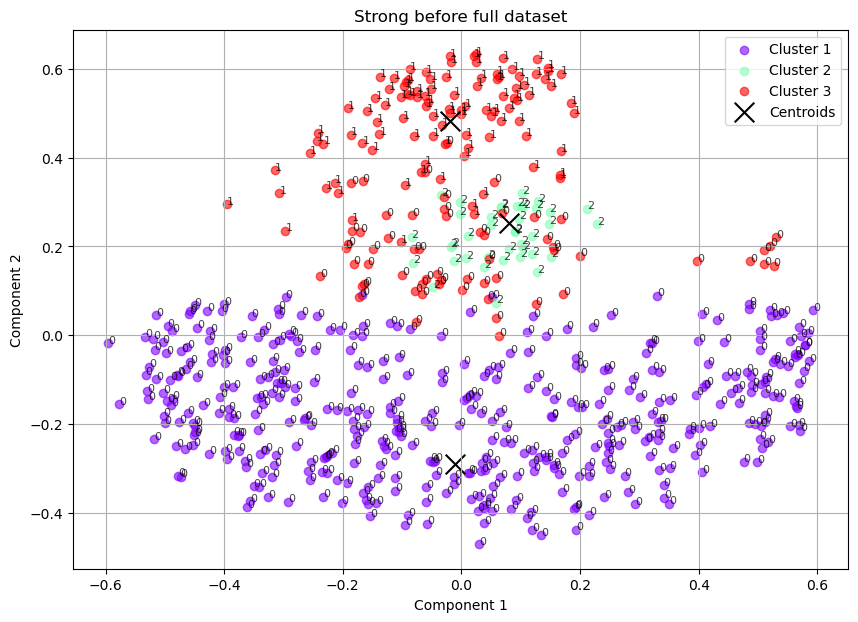

In [73]:
# Apply PCA after K-Means clustering for 2D visualization
X_2D_pca, centroids_2D_pca = reduce_to_2D_pca(feats_np_norm, centroids)

# Plot the 2D clusters with centroids and true labels
plot_2D_clusters_with_labels(X_2D_pca, centroids_2D_pca, idx, labels_np, K)
